# Project - Image Classification and Regression
Jean-Louis Truong

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.patches as patches
import keras

C:\Users\trace\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Keras modules
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten, Input, UpSampling2D
from keras.optimizers import SGD, Adam

In [3]:
#mp1.py functions

import matplotlib.pyplot as plt
#matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


#im = generate_a_rectangle(10, True)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
#plt.show()

#im = generate_a_disk(10)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
#plt.show()

#[im, v] = generate_a_triangle(20, False)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
#plt.show()

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


# Simple Classification

We generate the geometric shapes. We transform the category list Y_train into a class list.

In [4]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = np_utils.to_categorical(Y_train, 3) 

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


We create a first model, using stochastic gradient descent optimizer.

In [5]:
model = Sequential([Dense(3, input_shape=(5184,)), Activation('softmax')])
sgd = SGD(lr=0.003, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=100, batch_size=32)

Epoch 1/100
300/300 [==============================] - 0s 919us/step - loss: 4.0704 - acc: 0.3800
Epoch 2/100
300/300 [==============================] - 0s 113us/step - loss: 2.0185 - acc: 0.5367
Epoch 3/100
300/300 [==============================] - 0s 103us/step - loss: 0.5939 - acc: 0.7833
Epoch 4/100
300/300 [==============================] - 0s 93us/step - loss: 0.5821 - acc: 0.8300
Epoch 5/100
300/300 [==============================] - 0s 93us/step - loss: 0.2142 - acc: 0.8967
Epoch 6/100
300/300 [==============================] - 0s 106us/step - loss: 0.4460 - acc: 0.8567
Epoch 7/100
300/300 [==============================] - 0s 113us/step - loss: 0.1648 - acc: 0.9467
Epoch 8/100
300/300 [==============================] - 0s 120us/step - loss: 0.1301 - acc: 0.9633
Epoch 9/100
300/300 [==============================] - 0s 143us/step - loss: 0.1006 - acc: 0.9633
Epoch 10/100
300/300 [==============================] - 0s 120us/step - loss: 0.1106 - acc: 0.9467
Epoch 11/100
300/300 

300/300 [==============================] - 0s 130us/step - loss: 0.0097 - acc: 1.0000
Epoch 84/100
300/300 [==============================] - 0s 113us/step - loss: 0.0101 - acc: 1.0000
Epoch 85/100
300/300 [==============================] - 0s 96us/step - loss: 0.0097 - acc: 1.0000
Epoch 86/100
300/300 [==============================] - 0s 126us/step - loss: 0.0097 - acc: 1.0000
Epoch 87/100
300/300 [==============================] - 0s 133us/step - loss: 0.0091 - acc: 1.0000
Epoch 88/100
300/300 [==============================] - 0s 106us/step - loss: 0.0091 - acc: 1.0000
Epoch 89/100
300/300 [==============================] - 0s 136us/step - loss: 0.0098 - acc: 1.0000
Epoch 90/100
300/300 [==============================] - 0s 113us/step - loss: 0.0095 - acc: 1.0000
Epoch 91/100
300/300 [==============================] - 0s 110us/step - loss: 0.0089 - acc: 1.0000
Epoch 92/100
300/300 [==============================] - 0s 123us/step - loss: 0.0090 - acc: 1.0000
Epoch 93/100
300/300 [==

We then check our classifier. The prediction are accurate for each geometric shapes.

In [6]:
X_test = generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 0., 1.]], dtype=float32)

In [7]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

In [8]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

Now, we try the Adam optimizer.

In [9]:
model2 = Sequential([Dense(3, input_shape=(5184,)), Activation('softmax')])
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.fit(X_train, Y_train, batch_size=32, epochs=100)

Epoch 1/100
300/300 [==============================] - 0s 552us/step - loss: 1.6453 - acc: 0.3667
Epoch 2/100
300/300 [==============================] - 0s 123us/step - loss: 0.8092 - acc: 0.6267
Epoch 3/100
300/300 [==============================] - 0s 116us/step - loss: 0.6637 - acc: 0.6667
Epoch 4/100
300/300 [==============================] - 0s 120us/step - loss: 0.4171 - acc: 0.8300
Epoch 5/100
300/300 [==============================] - 0s 116us/step - loss: 0.3185 - acc: 0.9133
Epoch 6/100
300/300 [==============================] - 0s 106us/step - loss: 0.2490 - acc: 0.9567
Epoch 7/100
300/300 [==============================] - 0s 130us/step - loss: 0.2393 - acc: 0.9600
Epoch 8/100
300/300 [==============================] - 0s 130us/step - loss: 0.2056 - acc: 0.9600
Epoch 9/100
300/300 [==============================] - 0s 133us/step - loss: 0.2240 - acc: 0.9133
Epoch 10/100
300/300 [==============================] - 0s 130us/step - loss: 0.1856 - acc: 0.9700
Epoch 11/100
300/30

300/300 [==============================] - 0s 106us/step - loss: 0.0094 - acc: 1.0000
Epoch 84/100
300/300 [==============================] - 0s 100us/step - loss: 0.0090 - acc: 1.0000
Epoch 85/100
300/300 [==============================] - 0s 106us/step - loss: 0.0095 - acc: 1.0000
Epoch 86/100
300/300 [==============================] - 0s 146us/step - loss: 0.0092 - acc: 1.0000
Epoch 87/100
300/300 [==============================] - 0s 116us/step - loss: 0.0083 - acc: 1.0000
Epoch 88/100
300/300 [==============================] - 0s 116us/step - loss: 0.0086 - acc: 1.0000
Epoch 89/100
300/300 [==============================] - 0s 136us/step - loss: 0.0085 - acc: 1.0000
Epoch 90/100
300/300 [==============================] - 0s 120us/step - loss: 0.0082 - acc: 1.0000
Epoch 91/100
300/300 [==============================] - 0s 113us/step - loss: 0.0081 - acc: 1.0000
Epoch 92/100
300/300 [==============================] - 0s 133us/step - loss: 0.0079 - acc: 1.0000
Epoch 93/100
300/300 [=

We check this new classifier. It is also accurate for each geometric shape.

In [10]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model2.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [11]:
X_test = generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0])
model2.predict(X_test)

array([[0., 0., 1.]], dtype=float32)

In [12]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
model2.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

# Visualisation of the solution

This is the solution for the SGD optimizer.

In [13]:
W = model.get_weights()[0]

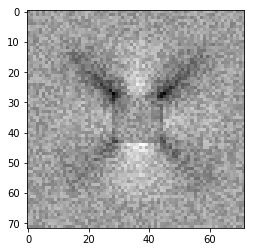

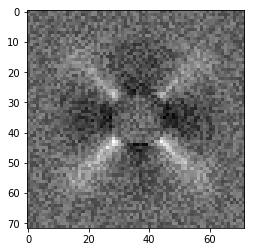

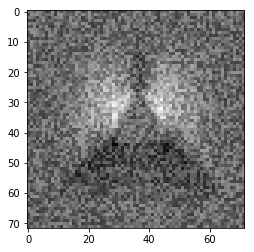

In [14]:
plt.imshow(W[:,0].reshape(72,72),cmap='gray')
plt.show()

plt.imshow(W[:,1].reshape(72,72),cmap='gray')
plt.show()

plt.imshow(W[:,2].reshape(72,72),cmap='gray')
plt.show()

This is the solution for the Adam optimizer.

In [15]:
W2 = model2.get_weights()[0]

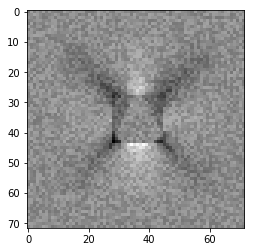

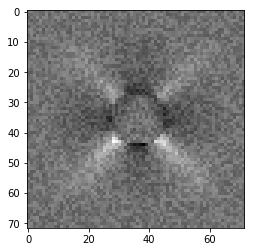

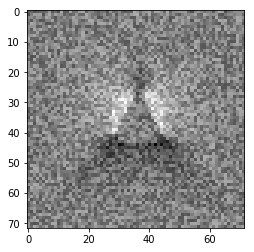

In [16]:
plt.imshow(W2[:,0].reshape(72,72),cmap='gray')
plt.show()

plt.imshow(W2[:,1].reshape(72,72),cmap='gray')
plt.show()

plt.imshow(W2[:,2].reshape(72,72),cmap='gray')
plt.show()

# A more difficult classification problem

We now generate geometric shape with random noise and will try to classify the shapes with the previous classifier.

In [17]:
[X_train2, Y_train2] = generate_dataset_classification(300, 20, True)
Y_train2 = np_utils.to_categorical(Y_train2, num_classes=3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [18]:
model3 = Sequential([Dense(3, input_shape=(5184,)), Activation('softmax')])
sgd = SGD(lr=0.003, decay=1e-6, momentum=0.9, nesterov=True)
model3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model3.fit(X_train2, Y_train2, epochs=100, batch_size=32)

Epoch 1/100
300/300 [==============================] - 0s 499us/step - loss: 6.4112 - acc: 0.3600
Epoch 2/100
300/300 [==============================] - 0s 103us/step - loss: 10.1970 - acc: 0.3667
Epoch 3/100
300/300 [==============================] - 0s 123us/step - loss: 10.2081 - acc: 0.3667
Epoch 4/100
300/300 [==============================] - 0s 106us/step - loss: 10.2081 - acc: 0.3667
Epoch 5/100
300/300 [==============================] - 0s 106us/step - loss: 10.2081 - acc: 0.3667
Epoch 6/100
300/300 [==============================] - 0s 120us/step - loss: 10.2081 - acc: 0.3667
Epoch 7/100
300/300 [==============================] - 0s 120us/step - loss: 10.2081 - acc: 0.3667
Epoch 8/100
300/300 [==============================] - 0s 136us/step - loss: 10.2081 - acc: 0.3667
Epoch 9/100
300/300 [==============================] - 0s 120us/step - loss: 10.2081 - acc: 0.3667
Epoch 10/100
300/300 [==============================] - 0s 120us/step - loss: 10.2081 - acc: 0.3667
Epoch 11/1

300/300 [==============================] - 0s 116us/step - loss: 10.2081 - acc: 0.3667
Epoch 83/100
300/300 [==============================] - 0s 110us/step - loss: 10.2081 - acc: 0.3667
Epoch 84/100
300/300 [==============================] - 0s 113us/step - loss: 10.2081 - acc: 0.3667
Epoch 85/100
300/300 [==============================] - 0s 116us/step - loss: 10.2081 - acc: 0.3667
Epoch 86/100
300/300 [==============================] - 0s 103us/step - loss: 10.2081 - acc: 0.3667
Epoch 87/100
300/300 [==============================] - 0s 106us/step - loss: 10.2081 - acc: 0.3667
Epoch 88/100
300/300 [==============================] - 0s 103us/step - loss: 10.2081 - acc: 0.3667
Epoch 89/100
300/300 [==============================] - 0s 106us/step - loss: 10.2081 - acc: 0.3667
Epoch 90/100
300/300 [==============================] - 0s 120us/step - loss: 10.2081 - acc: 0.3667
Epoch 91/100
300/300 [==============================] - 0s 126us/step - loss: 10.2081 - acc: 0.3667
Epoch 92/100


In [19]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [20]:
model3.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 186us/step


[10.799123980204264, 0.3299999996026357]

The classifier with SGD seems to be not accurate.
We now try with the Adam optimizer.

In [21]:
model4 = Sequential([Dense(3, input_shape=(5184,)), Activation('softmax')])
model4.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model4.fit(X_train2, Y_train2, batch_size=32, epochs=100)

Epoch 1/100
300/300 [==============================] - 0s 718us/step - loss: 2.4931 - acc: 0.3533
Epoch 2/100
300/300 [==============================] - 0s 130us/step - loss: 1.4850 - acc: 0.3267
Epoch 3/100
300/300 [==============================] - 0s 116us/step - loss: 1.2139 - acc: 0.4200
Epoch 4/100
300/300 [==============================] - 0s 100us/step - loss: 1.4732 - acc: 0.4733
Epoch 5/100
300/300 [==============================] - 0s 116us/step - loss: 1.1264 - acc: 0.4033
Epoch 6/100
300/300 [==============================] - 0s 116us/step - loss: 1.1127 - acc: 0.5067
Epoch 7/100
300/300 [==============================] - 0s 103us/step - loss: 0.9887 - acc: 0.5433
Epoch 8/100
300/300 [==============================] - 0s 136us/step - loss: 0.8827 - acc: 0.5633
Epoch 9/100
300/300 [==============================] - 0s 106us/step - loss: 0.8682 - acc: 0.5700
Epoch 10/100
300/300 [==============================] - 0s 116us/step - loss: 0.8581 - acc: 0.6067
Epoch 11/100
300/30

300/300 [==============================] - 0s 126us/step - loss: 0.4877 - acc: 0.8000
Epoch 84/100
300/300 [==============================] - 0s 126us/step - loss: 0.5433 - acc: 0.7700
Epoch 85/100
300/300 [==============================] - 0s 136us/step - loss: 0.5162 - acc: 0.7500
Epoch 86/100
300/300 [==============================] - 0s 106us/step - loss: 0.4506 - acc: 0.8333
Epoch 87/100
300/300 [==============================] - 0s 120us/step - loss: 0.4223 - acc: 0.8333
Epoch 88/100
300/300 [==============================] - 0s 106us/step - loss: 0.4220 - acc: 0.8367
Epoch 89/100
300/300 [==============================] - 0s 136us/step - loss: 0.4613 - acc: 0.7933
Epoch 90/100
300/300 [==============================] - 0s 126us/step - loss: 0.4911 - acc: 0.7567
Epoch 91/100
300/300 [==============================] - 0s 120us/step - loss: 0.5320 - acc: 0.7467
Epoch 92/100
300/300 [==============================] - 0s 133us/step - loss: 0.4360 - acc: 0.8367
Epoch 93/100
300/300 [=

In [22]:
model4.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 199us/step


[1.0775439516703287, 0.5666666666666667]

We have more accuracy with the Adam optimizer but the classifier still is not efficient enough.

We will then try a convolutional network.

In [23]:
X_train2 = X_train2.reshape(X_train2.shape[0],72,72,1)
model5 = Sequential()
model5.add(Conv2D(16, (5, 5), activation='relu',input_shape=(72, 72, 1)))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Flatten())
model5.add(Dense(3,activation='softmax'))
model5.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model5.fit(X_train2, Y_train2,batch_size=32, epochs=100)

Epoch 1/100
300/300 [==============================] - 1s 4ms/step - loss: 1.1774 - acc: 0.4033
Epoch 2/100
300/300 [==============================] - 1s 3ms/step - loss: 0.9503 - acc: 0.5367
Epoch 3/100
300/300 [==============================] - 1s 3ms/step - loss: 0.7829 - acc: 0.7933
Epoch 4/100
300/300 [==============================] - 1s 3ms/step - loss: 0.6471 - acc: 0.7900
Epoch 5/100
300/300 [==============================] - 1s 3ms/step - loss: 0.5609 - acc: 0.8033
Epoch 6/100
300/300 [==============================] - 1s 3ms/step - loss: 0.5051 - acc: 0.8233
Epoch 7/100
300/300 [==============================] - 1s 3ms/step - loss: 0.4282 - acc: 0.8967
Epoch 8/100
300/300 [==============================] - 1s 3ms/step - loss: 0.4184 - acc: 0.8700
Epoch 9/100
300/300 [==============================] - 1s 3ms/step - loss: 0.3667 - acc: 0.9067
Epoch 10/100
300/300 [==============================] - 1s 3ms/step - loss: 0.3392 - acc: 0.9033
Epoch 11/100
300/300 [=================

300/300 [==============================] - 1s 3ms/step - loss: 0.0099 - acc: 1.0000
Epoch 85/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0089 - acc: 1.0000
Epoch 86/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0086 - acc: 1.0000
Epoch 87/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0088 - acc: 1.0000
Epoch 88/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0080 - acc: 1.0000
Epoch 89/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0087 - acc: 1.0000
Epoch 90/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0081 - acc: 1.0000
Epoch 91/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0078 - acc: 1.0000
Epoch 92/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0074 - acc: 1.0000
Epoch 93/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0073 - acc: 1.0000
Epoch 94/100
300/300 [=====================

In [24]:
X_test = X_test.reshape(X_test.shape[0],72,72,1)

In [25]:
model5.evaluate(X_test,Y_test)

300/300 [==============================] - 0s 2ms/step


[1.14033105691274, 0.6766666674613953]

The classification is now more accurate.

# A regression problem

I did not find a solution to this problem. What follows is my attempt.

First, we generate and visualize the data.

In [26]:
[X_train3, Y_train3] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


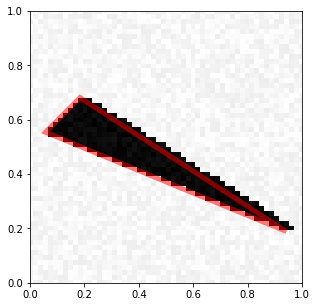

In [27]:
visualize_prediction(X_train3[0], Y_train3[0])

In [28]:
[X_test2, Y_test2] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Then we can normalize the vertices of the triangle, using the maximum and the minimum of the coordinates of all vertices, so that all the coordinates is between -1 and 1.

In [29]:
x1_M = np.max(Y_train3[:,0])
x1_m = np.min(Y_train3[:,0])
x2_M = np.max(Y_train3[:,2])
x2_m = np.min(Y_train3[:,2])
x3_M = np.max(Y_train3[:,4])
x3_m = np.min(Y_train3[:,4])
y1_M = np.max(Y_train3[:,1])
y1_m = np.min(Y_train3[:,1])
y2_M = np.max(Y_train3[:,3])
y2_m = np.min(Y_train3[:,3])
y3_M = np.max(Y_train3[:,5])
y3_m = np.min(Y_train3[:,5])

x1_Mt = np.max(Y_test2[:,0])
x1_mt = np.min(Y_test2[:,0])
x2_Mt = np.max(Y_test2[:,2])
x2_mt = np.min(Y_test2[:,2])
x3_Mt = np.max(Y_test2[:,4])
x3_mt = np.min(Y_test2[:,4])
y1_Mt = np.max(Y_test2[:,1])
y1_mt = np.min(Y_test2[:,1])
y2_Mt = np.max(Y_test2[:,3])
y2_mt = np.min(Y_test2[:,3])
y3_Mt = np.max(Y_test2[:,5])
y3_mt = np.min(Y_test2[:,5])

x_M = np.max(np.array([x1_M,x2_M,x3_M]))
x_m = np.min(np.array([x1_m,x2_m,x3_m]))
y_M = np.max(np.array([y1_M,y2_M,y3_M]))
y_m = np.min(np.array([y1_m,y2_m,y3_m]))

x_Mt = np.max(np.array([x1_Mt,x2_Mt,x3_Mt]))
x_mt = np.min(np.array([x1_mt,x2_mt,x3_mt]))
y_Mt = np.max(np.array([y1_Mt,y2_Mt,y3_Mt]))
y_mt = np.min(np.array([y1_mt,y2_mt,y3_mt]))

In [30]:
Y_train3_bis = np.copy(Y_train3)
Y_train3_bis[:,0] = 2*(Y_train3_bis[:,0] - x_m)/(x_M-x_m) - 1
Y_train3_bis[:,2] = 2*(Y_train3_bis[:,2] - x_m)/(x_M-x_m) - 1
Y_train3_bis[:,4] = 2*(Y_train3_bis[:,4] - x_m)/(x_M-x_m) - 1
Y_train3_bis[:,1] = 2*(Y_train3_bis[:,1] - y_m)/(y_M-y_m) - 1
Y_train3_bis[:,3] = 2*(Y_train3_bis[:,3] - y_m)/(y_M-y_m) - 1
Y_train3_bis[:,5] = 2*(Y_train3_bis[:,5] - y_m)/(y_M-y_m) - 1

Y_test2_bis = np.copy(Y_test2)
Y_test2_bis[:,0] = 2*(Y_test2_bis[:,0] - x_mt)/(x_Mt-x_mt) - 1
Y_test2_bis[:,2] = 2*(Y_test2_bis[:,2] - x_mt)/(x_Mt-x_mt) - 1
Y_test2_bis[:,4] = 2*(Y_test2_bis[:,4] - x_mt)/(x_Mt-x_mt) - 1
Y_test2_bis[:,1] = 2*(Y_test2_bis[:,1] - y_mt)/(y_Mt-y_mt) - 1
Y_test2_bis[:,3] = 2*(Y_test2_bis[:,3] - y_mt)/(y_Mt-y_mt) - 1
Y_test2_bis[:,5] = 2*(Y_test2_bis[:,5] - y_mt)/(y_Mt-y_mt) - 1

In [31]:
model6 = Sequential()
model6.add(Conv2D(16, (5, 5), activation='relu',input_shape=(72,72,1)))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Flatten())
model6.add(Dense(128,activation='softmax'))
model6.add(Dense(256,activation='softmax'))
model6.add(Dense(256,activation='softmax'))
model6.add(Dense(6,activation='softmax'))
sgd = SGD(lr=0.003, decay=1e-6, momentum=0.9, nesterov=True)
model6.compile(loss='mean_squared_error', optimizer='adam')
model6.fit(X_train3.reshape(X_train3.shape[0],72,72,1), Y_train3_bis, epochs=100, batch_size=32)

Epoch 1/100
300/300 [==============================] - 2s 6ms/step - loss: 0.3756
Epoch 2/100
300/300 [==============================] - 1s 4ms/step - loss: 0.3755
Epoch 3/100
300/300 [==============================] - 1s 4ms/step - loss: 0.3755
Epoch 4/100
300/300 [==============================] - 1s 4ms/step - loss: 0.3754
Epoch 5/100
300/300 [==============================] - 1s 4ms/step - loss: 0.3754
Epoch 6/100
300/300 [==============================] - 1s 4ms/step - loss: 0.3754
Epoch 7/100
300/300 [==============================] - 1s 4ms/step - loss: 0.3754
Epoch 8/100
300/300 [==============================] - 1s 4ms/step - loss: 0.3754
Epoch 9/100
300/300 [==============================] - 1s 4ms/step - loss: 0.3753
Epoch 10/100
300/300 [==============================] - 1s 4ms/step - loss: 0.3753
Epoch 11/100
300/300 [==============================] - 1s 4ms/step - loss: 0.3753
Epoch 12/100
300/300 [==============================] - 1s 4ms/step - loss: 0.3753
Epoch 13/100


300/300 [==============================] - 1s 5ms/step - loss: 0.3751
Epoch 100/100
300/300 [==============================] - 1s 4ms/step - loss: 0.3751


In [32]:
model6.evaluate(X_test2.reshape(X_test2.shape[0],72,72,1),Y_test2_bis)

300/300 [==============================] - 1s 2ms/step


0.36489617864290874

In [33]:
Y = model6.predict((X_test2.reshape(X_test2.shape[0],72,72,1)))

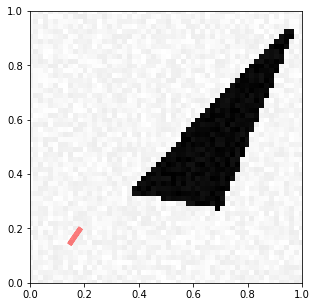

In [34]:
visualize_prediction(X_test2[0], Y[0])

We get a low value for the loss function. However, when we try to visualize the prediction, it is pretty inaccurate.

# Image denoising

We now modify the generate function to generate pairs of images.

In [35]:
#pair of rectangles
def generate_a_rectangle2(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise),generate_a_drawing(figsize, U, V, noise=0)

# pair of disks
def generate_a_disk2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, noise=0)

#pair of triangles
def generate_a_triangle2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata1 = generate_a_drawing(figsize, U, V, noise)
    imdata2 = generate_a_drawing(figsize, U, V, noise=0)
    return [imdata1, [U[0], V[0], U[1], V[1], U[2], V[2]]],[imdata2, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification2(nb_samples, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    X_n = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        noise = np.random.random()*100
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X_n[i], X[i] = generate_a_rectangle2(noise, free_location)
        elif category == 1: 
            X_n[i], X[i] = generate_a_disk2(noise, free_location)
        else:
            [X_n[i], V_n],[X[i], V] = generate_a_triangle2(noise, free_location)
    X = X /255
    X_n = (X_n + noise) / (255 + 2 * noise)
    return [X_n, X]

def generate_test_set_classification2():
    np.random.seed(42)
    [X_n_test,X_test] = generate_dataset_classification2(300, True)
    return [X_n_test,X_test]

We create a deep network to solve the problem.

In [36]:
X_n, X = generate_dataset_classification2(nb_samples=300, free_location=True)
X_n = X_n.reshape(X_n.shape[0], 72, 72, 1)
X = X.reshape(X.shape[0], 72, 72, 1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [37]:
X_n_test, X_test = generate_dataset_classification2(nb_samples=300, free_location=True)
X_n_test = X_n_test.reshape(X_test.shape[0], 72, 72, 1)
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


We use autoencoder to build our deep network.

In [38]:
input_img = Input(shape=(72, 72, 1))  # image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics = ['accuracy'])

In [39]:
autoencoder.fit(X_n, X,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_data=(X_n_test, X_test))

Train on 300 samples, validate on 300 samples
Epoch 1/20
300/300 [==============================] - 10s 32ms/step - loss: 0.4587 - acc: 0.8295 - val_loss: 0.2811 - val_acc: 0.9097
Epoch 2/20
300/300 [==============================] - 9s 29ms/step - loss: 0.2403 - acc: 0.9066 - val_loss: 0.2055 - val_acc: 0.9097
Epoch 3/20
300/300 [==============================] - 9s 30ms/step - loss: 0.1421 - acc: 0.9407 - val_loss: 0.1000 - val_acc: 0.9665
Epoch 4/20
300/300 [==============================] - 9s 29ms/step - loss: 0.0505 - acc: 0.9871 - val_loss: 0.0431 - val_acc: 0.9829
Epoch 5/20
300/300 [==============================] - 9s 29ms/step - loss: 0.0253 - acc: 0.9913 - val_loss: 0.0357 - val_acc: 0.9866
Epoch 6/20
300/300 [==============================] - 9s 31ms/step - loss: 0.0225 - acc: 0.9923 - val_loss: 0.0253 - val_acc: 0.9904
Epoch 7/20
300/300 [==============================] - 9s 29ms/step - loss: 0.0213 - acc: 0.9924 - val_loss: 0.0260 - val_acc: 0.9893
Epoch 8/20
300/300 [==

We get good results as the model is very accurate.

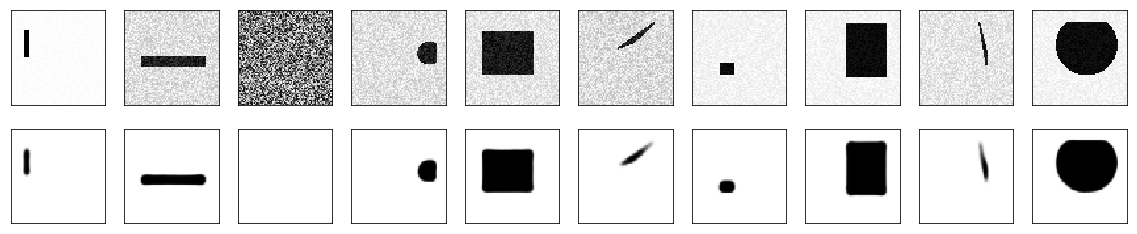

In [40]:
decoded_imgs = autoencoder.predict(X_n_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_n_test[i].reshape(72, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(72, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can now reconstruct well the images, except for the third one which has too much noise.